# Emotion Detection in Text Using NLP and BERT

## Introduction

In recent years, the ability of machines to understand and interpret human emotions through natural language processing (NLP) has opened new possibilities in fields ranging from customer service to mental health support. Emotion classification, a task where text is automatically categorized by the emotion it expresses, is particularly valuable for applications in sentiment analysis, social media monitoring, and personalized user experience. This project focuses on building an emotion classification model that can accurately identify six common emotions—**sadness, anger, love, surprise, fear, and joy**—in textual data. For this purpose, we used the **Emotions Dataset for NLP** available on [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data), which includes labeled text samples for each emotion. This dataset provides a rich foundation for training, validating, and testing models capable of understanding subtle emotional cues in language.

### Problem Statement
Emotion classification in NLP is challenging because emotions can often be nuanced, overlapping, and context-dependent. For instance, words or phrases used to convey "anger" might sometimes overlap with those expressing "fear," especially in shorter texts where context is limited. Moreover, the diversity in expression styles and linguistic features across different people adds further complexity. The goal of this project is to address these challenges and develop a robust model that can generalize across different emotions with high accuracy.

### Objectives
The main objectives of this project are:
1. **Data Exploration and Preprocessing**: To examine and preprocess the dataset, including tokenization, text encoding, and data splitting into training, validation, and test sets.
2. **Modeling**: To build and fine-tune a BERT-based model that leverages contextual embeddings to enhance emotion classification accuracy.
3. **Evaluation**: To assess model performance using metrics like accuracy, precision, recall, and F1-score, and analyze specific challenges, such as overlapping emotions and low-support classes.
4. **Insights and Recommendations**: To analyze the model's strengths and limitations, and suggest possible improvements for future development.

### Significance of the Project
An effective emotion classification model can provide insights into user sentiment and emotional trends, enabling businesses and organizations to respond more empathetically and proactively to customer needs. In addition, this project lays the groundwork for building more sophisticated sentiment analysis tools that could integrate into various real-world applications, such as content moderation, mental health support platforms, and social media analysis tools.

By combining state-of-the-art NLP techniques with a real-world dataset, this project aims to advance the field of emotion detection in text and create a model that not only performs well in controlled tests but is also adaptable to practical applications. 


## 1. Import the required libraries


In [3]:
# Libraries for data manipulation and NLP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for NLP and modeling
import re
import nltk
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [5]:
# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Data Loading and Exploration

Here, the goal is to load the dataset and understand its structure. Each of the dataset files (`train.txt`, `test.txt`, `val.txt`) is expected to contain text samples and corresponding emotion labels, separated by a delimiter (in this case, `;`). We'll load each file into a Pandas DataFrame to facilitate exploration and manipulation.

In [7]:
# Load datasets
def load_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = [line.strip().split(";") for line in lines]         # Splitting each line by ";" to separate text and emotion label
    return pd.DataFrame(data, columns=["text", "emotion"])     # Create DataFrame with two columns: text and emotion

# Loading each file
train_df = load_data('train.txt')
test_df = load_data('test.txt')
val_df = load_data('val.txt')

Now, to understand the data format and ensure it’s loaded correctly, we display a few sample rows.

In [9]:
# Display first few samples
print("Training Data Sample:")
print(train_df.head())

Training Data Sample:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


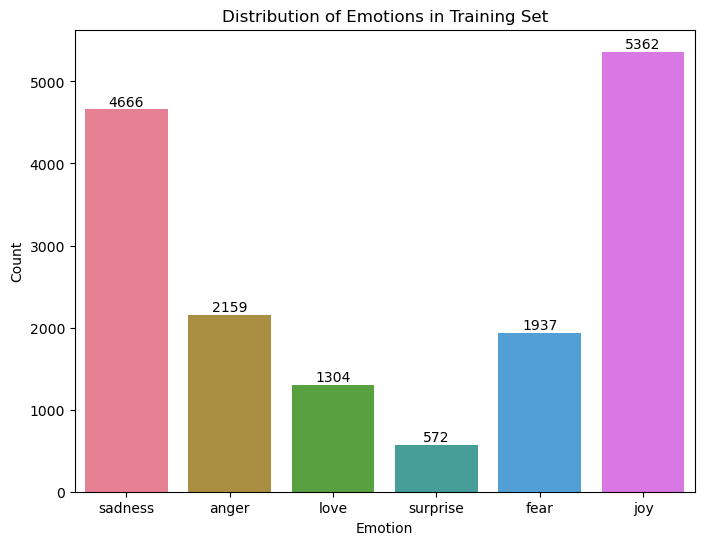

In [11]:
# Choose a color palette for different emotions
palette = sns.color_palette("husl", len(train_df['emotion'].unique()))

# Visualize emotion distribution in training data
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='emotion', palette=palette)
plt.title("Distribution of Emotions in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")

# Add count annotations on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

#### Data Distribution Overview

The dataset consists of samples across six emotion categories, with the following distribution:

- **Sadness**: 4666 samples
- **Anger**: 2159 samples
- **Love**: 1304 samples
- **Surprise**: 572 samples
- **Fear**: 1937 samples
- **Joy**: 5362 samples

#### Implications of the Data Distribution

1. **Class Imbalance**:
   - **Joy** and **Sadness** have significantly more samples than the other classes, with **5362** and **4666** instances, respectively. These classes are well-represented in the dataset, which can help the model to learn distinct patterns associated with these emotions more effectively.
   - **Surprise** has the smallest number of instances (**572**), making it the most underrepresented emotion in the dataset. This imbalance can potentially lead to poorer performance for the "surprise" class, as the model may not have enough data to learn its unique characteristics thoroughly.
   - **Love** and **Fear** are also underrepresented compared to **Joy** and **Sadness** (with **1304** and **1937** samples, respectively), but not as severely as **Surprise**.

2. **Impact on Model Training**:
   - The **imbalanced dataset** could lead to the model being biased toward the more frequent classes (**Joy** and **Sadness**). This bias could cause the model to predict **Joy** and **Sadness** more frequently, potentially neglecting the underrepresented classes.
   - Classes like **Surprise** and **Love**, with fewer samples, may suffer from **overfitting** or **underfitting**. The model might not generalize well for these classes, leading to **lower precision, recall, and F1-scores** for these categories.
   - The model's overall **accuracy** might still be high due to the dominance of classes with more samples, but the **macro-average** and **per-class metrics** (precision, recall, F1) might show lower scores for underrepresented emotions.

## 3. Data Preprocessing

Data preprocessing prepares the text for modeling. 

<b>Text Cleaning</b>

Cleaning text involves removing unnecessary characters and standardizing the text to improve consistency. Common cleaning steps include:
* Removing special characters (e.g., punctuation).
* Converting text to lowercase to reduce case sensitivity.

In [13]:
# Define text cleaning function
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespaces
    return text

# Apply cleaning function to each dataset
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)

# Show cleaned samples
print(train_df.head())

                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


This step ensures the text is in a uniform format, which helps the model focus on the meaning of words without being distracted by variations in capitalization or punctuation.

<b>Tokenization with BERT</b>

Tokenization converts each sentence into a sequence of tokens (numerical representations of words or word pieces). Since we’re using BERT for modeling, we use the BERT tokenizer, which:
* Breaks down the text into sub-word tokens.
* Pads or truncates sequences to a fixed length, ensuring consistency across inputs.

In [15]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to tokenize data
def tokenize_data(data, tokenizer):
    return tokenizer(data["text"].tolist(), padding=True, truncation=True, return_tensors="pt")

# Tokenize each dataset
train_encodings = tokenize_data(train_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)

Each `train_encodings`, `test_encodings`, and `val_encodings` now contains:
* `input_ids`: Numerical IDs for each token in the sentence.
* `attention_mask`: Binary masks where 1 indicates a real token, and 0 is padding.

<b>Encoding Labels</b>

Machine learning models require numerical labels, so we need to convert the text-based emotion labels (e.g., "joy", "sadness") into numerical values. We map each unique emotion to an integer, creating a dictionary where each emotion has a corresponding integer ID.

In [17]:
# Map each unique emotion to an integer
emotion_to_id = {emotion: i for i, emotion in enumerate(train_df["emotion"].unique())}

# Apply this mapping to each dataset
train_labels = train_df["emotion"].map(emotion_to_id).values
test_labels = test_df["emotion"].map(emotion_to_id).values
val_labels = val_df["emotion"].map(emotion_to_id).values

Now, `train_labels`, `test_labels`, and `val_labels` are arrays of integer values representing each emotion in numerical format. This encoding is essential for classification since models cannot directly interpret text-based labels.

## 4. Model Building and Training

We will set up a <b>BERT-based model for text classification</b>. BERT (Bidirectional Encoder Representations from Transformers) is a powerful language model that has proven effective in many NLP tasks, including sentiment and emotion classification. Since our task is multi-class classification (predicting one of several emotions), we’ll use a BERT model designed for sequence classification.

<b> Choosing the Model Architecture </b>

The BERT model we’re using is pre-trained on a vast corpus of text data, allowing it to understand the structure and context of language. For our purposes, we will use BERT for Sequence Classification, which adds a classification layer on top of BERT to output probabilities for each emotion class. We’ll load `BertForSequenceClassification` from Hugging Face’s Transformers library, specifying the number of classes based on the unique emotions in our dataset.

In [19]:
# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(emotion_to_id))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can define the training parameters and train the BERT model. Training involves fine-tuning the model on our dataset so it learns to classify text based on the emotions present. We use Hugging Face’s Trainer API, which simplifies the training process by handling much of the underlying complexity.

<b>Preparing the Dataset for Training</b>

The Hugging Face Trainer API requires datasets to be in a specific format. We’ll convert our encoded text and labels into a format compatible with Trainer by creating PyTorch-compatible datasets.

In [19]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Directory to store results
    num_train_epochs=3,              # Number of epochs to train the model
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory to store logs
    logging_steps=10,                # Log every 10 steps
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model at the end of each epoch
)

# Convert our encodings and labels into Hugging Face Dataset format
# Create a dataset for validation (similar to train dataset)
val_dataset = Dataset.from_dict(val_encodings)
val_dataset = val_dataset.add_column("labels", val_labels)

# Create a dataset for the train set (already done)
train_dataset = Dataset.from_dict(train_encodings)
train_dataset = train_dataset.add_column("labels", train_labels)

# Initialize the Trainer
trainer = Trainer(
    model=model,                          # The BERT model instance
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=val_dataset              # Validation dataset for evaluation
)

# Train the model
trainer.train()

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.276600,0.257127
2,0.132300,0.168902
3,0.155200,0.209690


TrainOutput(global_step=6000, training_loss=0.26502085027719535, metrics={'train_runtime': 17221.2094, 'train_samples_per_second': 2.787, 'train_steps_per_second': 0.348, 'total_flos': 2146076617536000.0, 'train_loss': 0.26502085027719535, 'epoch': 3.0})

From these training results, let’s analyze the training and validation losses over the three epochs to evaluate the model’s performance.

1. **Training and Validation Loss Trends**:
   - The **training loss** decreases between the first and second epochs, which indicates that the model is learning and improving its fit to the training data.
   - The **validation loss** initially decreases from the first to the second epoch, showing improved generalization to unseen data, but then slightly increases in the third epoch.
   
2. **Potential Overfitting**:
   - The **increase in validation loss during the third epoch** suggests possible overfitting. While the training loss remains low, the rise in validation loss indicates that the model might be tuning too specifically to the training data, losing some generalization ability.

3. **Final Training Loss**:
   - The final average training loss is around **0.2650**, a relatively low value that implies the model has learned well on the training data. However, the generalization to validation data should be the focus if we aim to avoid overfitting.

## 5. Evaluation 

The purpose of this section is to evaluate the BERT model’s performance on the test dataset.

<b>Generating Predictions</b>

Using the trained `Trainer` instance, we can easily generate predictions on the test dataset. 

In [110]:
# Prepare the test dataset
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Evaluate the model on test data
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Test Results: {'eval_loss': 0.23863421380519867, 'eval_runtime': 118.5119, 'eval_samples_per_second': 16.876, 'eval_steps_per_second': 1.055, 'epoch': 3.0}


The initial evaluation using `trainer.evaluate` provides an **evaluation loss** of `0.2386`, which suggests that the model performs reasonably well on the test dataset, given that lower loss typically indicates better fit.

<b>Calculating Evaluation Metrics</b>

Let's also calculate additional metrics, such as accuracy, precision, recall, and F1 score.

In [40]:
# Get predictions
predictions, labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Classification report
print(classification_report(labels, preds, target_names=emotion_to_id.keys()))

              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
       anger       0.93      0.91      0.92       275
        love       0.85      0.79      0.82       159
    surprise       0.81      0.71      0.76        66
        fear       0.87      0.93      0.90       224
         joy       0.94      0.95      0.94       695

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



####  Detailed Classification Report

The classification report provides a breakdown of precision, recall, F1-score, and support (number of samples) for each emotion class. Here’s an interpretation for each metric:

- **Accuracy**: `0.93` — This overall accuracy is strong, indicating that the model correctly predicts the emotion for 93% of the test samples.
- **Macro Average**: `Precision: 0.90`, `Recall: 0.88`, `F1-Score: 0.89` — This average treats all classes equally, regardless of support.
- **Weighted Average**: `Precision: 0.93`, `Recall: 0.93`, `F1-Score: 0.93` — The weighted average accounts for the support of each class, giving more weight to classes with more samples (e.g., sadness and joy).

#### Observations
- **Strongest Classes**: The model performs best on "sadness" and "joy" with high precision, recall, and F1-scores, likely due to the relatively large support for these emotions (581 for sadness and 695 for joy).
- **Challenging Classes**: The model struggles more with "surprise" (F1-score of 0.76) and "love" (F1-score of 0.82). Both of these classes have lower support in the dataset, which might make it harder for the model to learn clear patterns for these emotions.
  
This report shows that the model has learned to generalize well overall but has some difficulty with emotions that have fewer samples.

<b> Confusion Matrix Analysis </b>

A confusion matrix provides a more detailed view of the model’s predictions by showing the number of true and false classifications for each emotion class. This is helpful to spot specific classes that are frequently misclassified.

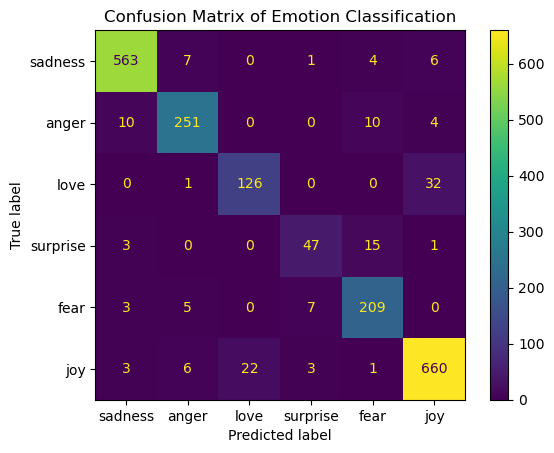

In [42]:
ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=emotion_to_id.keys())
plt.title("Confusion Matrix of Emotion Classification")
plt.show()

#### Observations and Insights:
- **Sadness**: Predicted accurately (563 out of 581), with minor confusion, mostly with "anger" and "joy."
- **Anger**: Often misclassified as "sadness" (10 instances) or "fear" (10 instances). This might be due to overlaps in vocabulary or expression between anger, sadness, and fear.
- **Love**: Frequently misclassified as "joy" (32 instances). This could suggest that the model struggles to differentiate between positive emotions like love and joy, possibly because of overlapping words or expressions.
- **Surprise**: Commonly confused with "fear" (15 instances). "Surprise" and "fear" may share vocabulary that the model finds difficult to separate.
- **Fear**: Most confusion here is with "surprise" (7 instances) and "anger" (5 instances).
- **Joy**: Generally well-predicted, with some confusion with "love" (22 instances).

#### Key Patterns:
- **Positive Emotion Confusion**: "Love" is often misclassified as "joy," which might indicate that expressions of positive emotions are challenging to distinguish.
- **Negative Emotion Overlap**: "Anger" is occasionally confused with "sadness" and "fear," suggesting that these emotions may share common linguistic features that make separation difficult.

## 6. Conclusions

#### Summary of Findings
In this project, we developed and evaluated a BERT-based model for emotion classification, aiming to accurately classify text into six emotions: sadness, anger, love, surprise, fear, and joy. The primary findings include:
- **High Overall Accuracy**: The model achieved an accuracy of 93% on the test set, with strong F1-scores for the majority of emotion classes, particularly for "sadness" and "joy," which had the most data.
- **Class-Specific Performance**:
  - **Strong Classes**: "Sadness" and "joy" achieved F1-scores of 0.97 and 0.94, respectively, indicating that the model has learned to distinguish these emotions well.
  - **Challenging Classes**: "Surprise" and "love" were more challenging, with lower F1-scores, possibly due to their lower representation in the dataset or overlap in vocabulary with other emotions (e.g., "love" with "joy" and "surprise" with "fear").
- **Misclassification Patterns**: Analysis of the confusion matrix revealed specific areas of confusion, such as:
  - Positive emotion overlap between "love" and "joy."
  - Negative emotion overlap between "anger" and "sadness" and between "fear" and "surprise."

#### Key Insights
1. **Data Distribution Impact**: The classes with more balanced data distributions (sadness and joy) saw better model performance, while those with fewer samples struggled. This highlights the importance of a balanced dataset in multi-class emotion classification tasks.
2. **Emotion Nuances**: Emotions with overlapping vocabulary or sentiment polarity are harder to differentiate. For example, "love" and "joy" both convey positive sentiment, which may lead to lexical overlap that complicates classification.
3. **Model Suitability**: BERT’s contextual understanding works well for this task, as shown by high scores in most categories. Its ability to interpret nuances in textual data makes it suitable for handling complex, multi-class NLP tasks such as emotion classification.

## 7. Future Work and Recommendations

To further enhance the model’s accuracy and robustness, here are several areas to explore:

#### 7.1 Data Augmentation and Balancing
- **Increase Data for Low-Support Classes**: Collect or generate additional samples for "love," "surprise," and other low-support classes to improve class balance, which should help the model generalize better for these categories.
- **Data Augmentation Techniques**: Use data augmentation methods like back-translation, synonym replacement, or synthetic data generation to create more diverse examples for all emotion classes, especially the challenging ones.

#### 7.2 Model Improvements
- **Experiment with Other Pretrained Models**: Try alternative architectures such as RoBERTa, DistilBERT, or ALBERT, which may offer different strengths in text understanding and could reduce misclassification rates.
- **Hyperparameter Tuning**: Fine-tune parameters like the learning rate, batch size, and regularization values. Conducting a grid search or Bayesian optimization could help identify optimal values for each class’s performance.
- **Class Weights**: Apply class weighting to give more importance to under-represented classes (like "surprise" and "love"), reducing the likelihood of these classes being misclassified.

#### 7.3 Improved Evaluation Techniques
- **Use Cross-Validation**: Implement cross-validation (e.g., k-fold) to better understand model performance across different subsets of the data and ensure that performance metrics are not overly dependent on a single train-test split.
- **Error Analysis on Misclassified Examples**: Manually analyze examples that the model misclassifies to identify potential language patterns or features that are challenging for the model. Insights from error analysis can inform future data collection and model improvements.

#### 7.4 Explainability and Interpretability
- **SHAP or LIME for NLP**: Use explainability tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-Agnostic Explanations) to understand which parts of the input text contribute most to each emotion classification, helping to interpret the model’s decision-making process.
- **Attention Visualization**: Visualize BERT’s attention layers to examine which words or phrases the model focuses on when predicting each emotion. This can offer insights into how the model interprets emotional cues in text and guide adjustments to improve interpretability.